# ベルヌーイ分布の学習と予測

## 準備

In [7]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 利用可能なフォント一覧を取得
available_fonts = [f.name for f in fm.fontManager.ttflist]
print("利用可能なフォント一覧:")
print(available_fonts)

# 優先フォント設定
font_families = []

if "Yu Gothic" in available_fonts:
    font_families.append("Yu Gothic")  # Windows向け日本語
    print("日本語フォント: Yu Gothic を使用します")
elif "Noto Sans CJK JP" in available_fonts:
    font_families.append("Noto Sans CJK JP")  # Linux向け日本語
    print("日本語フォント: Noto Sans CJK JP を使用します")
else:
    print("日本語フォントが見つかりません．")
    print("結果画像内の日本語が豆腐になる可能性があります")

# 欧文用フォントを追加（必ずカバーしておきたい）
font_families.append("DejaVu Sans")

# matplotlib に適用
plt.rcParams["font.family"] = font_families
print("最終的に使用するフォント順:", plt.rcParams["font.family"])

利用可能なフォント一覧:
['STIXSizeThreeSym', 'DejaVu Sans Mono', 'cmsy10', 'DejaVu Serif', 'cmss10', 'DejaVu Serif', 'cmex10', 'cmr10', 'DejaVu Sans', 'STIXSizeThreeSym', 'DejaVu Serif', 'DejaVu Sans', 'cmmi10', 'STIXGeneral', 'cmtt10', 'STIXNonUnicode', 'DejaVu Sans', 'STIXSizeTwoSym', 'DejaVu Sans', 'STIXGeneral', 'STIXSizeOneSym', 'DejaVu Sans Mono', 'STIXSizeFourSym', 'STIXNonUnicode', 'STIXNonUnicode', 'DejaVu Sans Display', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Sans Mono', 'STIXSizeFourSym', 'STIXGeneral', 'STIXSizeFiveSym', 'STIXSizeTwoSym', 'DejaVu Serif Display', 'cmb10', 'STIXNonUnicode', 'STIXGeneral', 'STIXSizeOneSym', 'Ubuntu', 'Ubuntu', 'Ubuntu Sans', 'Ubuntu Sans', 'Ubuntu', 'DejaVu Serif', 'Ubuntu Mono', 'Ubuntu', 'Ubuntu Mono', 'Ubuntu', 'Noto Sans CJK JP', 'DejaVu Sans', 'Ubuntu', 'Ubuntu Mono', 'Ubuntu Mono', 'DejaVu Sans Mono', 'Ubuntu', 'Ubuntu Sans Mono', 'Noto Serif CJK JP', 'DejaVu Sans Mono', 'Noto Sans CJK JP', 'Ubuntu', 'Noto Serif CJK JP', 'Ubuntu Mono', 'DejaVu 

## 学習の様子

前の解説に基づき、「**最初は性能が不明な、とあるスマホゲームのガチャで、レアキャラが当たる確率を推定する**」というシナリオでPythonのサンプルコードを作成します。

このシナリオは、コインの表裏と同様に「当たり(1)」か「ハズレ(0)」のベルヌーイ分布に従う事象と見なせます。

-----

### シナリオ設定

  * あるゲームのガチャがあり、レアキャラが当たる真の確率 `μ` は **0.3 (30%)** とします（この値は本来、我々には未知です）。
  * 我々は、この確率について**全く事前知識がない**と仮定し、事前分布として `Beta(μ|a=1, b=1)`（一様分布）を設定します。これは「0%から100%まで、どの確率も同様にありえそうだ」という立場を表します。
  * ガチャを50回引いて、その結果からレアキャラの排出確率 `μ` を学習し、次の1回で当たる確率を予測します。

-----

### コードの解説と結果の解釈

  * **上段のグラフ（予測確率の推移）**:

      * ガチャを引くたびに「次にレアが当たる確率」がどう変化するかを示します。
      * 最初はデータが少ないため予測が大きく揺れ動きますが、試行回数（データ）が増えるにつれて、予測確率が真の確率である **0.3** に収束していく様子が分かります。これが**学習**です。

  * **下段のグラフ（事後分布の変化）**:

      * これは、我々の「レア排出確率 `μ` はどのくらいの値か」という信念が、データを得ることでどう変化するかを示しています。
      * **Prior (N=0)**: 最初は平らな線（一様分布）で、「どの確率も同じくらいありえそう」と考えています。
      * **Posterior (N=5, 10, 50...)**: データが増えるにつれて、分布の山がどんどん鋭くなり、真の確率である **0.3** の周辺に集中していきます。これは「`μ` は0.3あたりにありそうだ」という確信が強まっていくことを意味します。不確実性が減少していく様子が視覚的に理解できます。

シミュレーションデータ (最初の20回): [0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0]
------------------------------


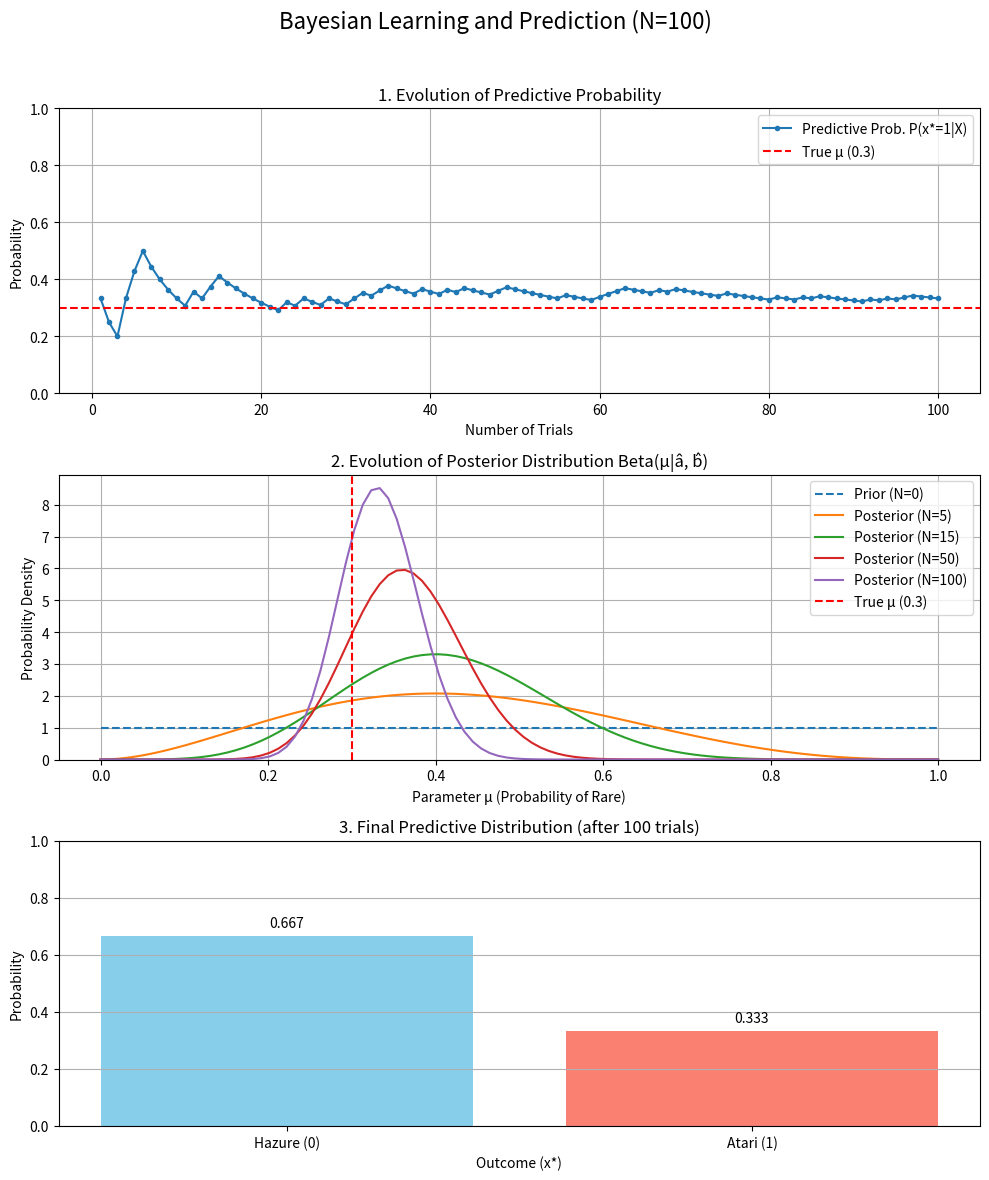

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# --- 1. シナリオ設定 ---

# ガチャの「真の」当たり確率 (本来は未知の値)
true_mu = 0.3

# 事前分布のハイパーパラメータ (a=1, b=1は一様分布で、事前知識がないことを示す)
a = 1
b = 1

# ガチャを引く回数
num_trials = 100

# ガチャの結果をシミュレーション (1が当たり, 0がハズレ)
# np.random.seed(0) # 再現性のためにシードを固定
data = np.random.rand(num_trials) < true_mu  # ベルヌーイ分布に従うデータ生成
print(f"シミュレーションデータ (最初の20回): {data[:20].astype(int)}")
print("-" * 30)


# --- 2. ベイズ学習と予測の過程を記録 ---

# 記録用のリスト
predictive_probabilities = []
posterior_params = []

for i in range(num_trials):
    # i回目までのデータで学習
    current_data = data[: i + 1]

    # 当たり(1)とハズレ(0)の数を数える
    N1 = np.sum(current_data)  # 当たりの数
    N0 = len(current_data) - N1  # ハズレの数

    # 事後分布のパラメータを計算 (学習)
    a_hat = a + N1
    b_hat = b + N0

    # 次に当たりが出る確率を予測
    pred_prob = a_hat / (a_hat + b_hat)

    # 結果を記録
    predictive_probabilities.append(pred_prob)
    posterior_params.append((a_hat, b_hat))

# 学習過程の表示は省略


# --- 3. 結果の可視化 ---

# FigureとAxesを3段で準備
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle(f"Bayesian Learning and Prediction (N={num_trials})", fontsize=16)

# --- プロット1: 予測確率の推移 ---
ax1.plot(
    range(1, num_trials + 1),
    predictive_probabilities,
    marker=".",
    linestyle="-",
    label="Predictive Prob. P(x*=1|X)",
)
ax1.axhline(y=true_mu, color="r", linestyle="--", label=f"True μ ({true_mu})")
ax1.set_xlabel("Number of Trials")
ax1.set_ylabel("Probability")
ax1.set_title("1. Evolution of Predictive Probability")
ax1.grid(True)
ax1.legend()
ax1.set_ylim(0, 1)


# --- プロット2: 事後分布の変化 ---
plot_points = [4, 14, 49, 99]  # 5, 15, 50, 100回目の試行後の分布をプロット
x = np.linspace(0, 1, 100)

# 初期状態（事前分布）
ax2.plot(x, beta.pdf(x, a, b), label=f"Prior (N=0)", linestyle="--")

# 各試行回数での事後分布
for point in plot_points:
    a_hat, b_hat = posterior_params[point]
    ax2.plot(x, beta.pdf(x, a_hat, b_hat), label=f"Posterior (N={point + 1})")

ax2.axvline(x=true_mu, color="r", linestyle="--", label=f"True μ ({true_mu})")
ax2.set_xlabel("Parameter μ (Probability of Rare)")
ax2.set_ylabel("Probability Density")
ax2.set_title("2. Evolution of Posterior Distribution Beta(μ|â, b̂)")
ax2.grid(True)
ax2.legend()
ax2.set_ylim(bottom=0)

# --- プロット3: 最終的な予測分布 ---
final_pred_prob = predictive_probabilities[-1]
outcomes = [0, 1]
probabilities = [1 - final_pred_prob, final_pred_prob]

bars = ax3.bar(outcomes, probabilities, color=["skyblue", "salmon"])
ax3.set_title(f"3. Final Predictive Distribution (after {num_trials} trials)")
ax3.set_ylabel("Probability")
ax3.set_xlabel("Outcome (x*)")
ax3.set_xticks([0, 1])
ax3.set_xticklabels(["Hazure (0)", "Atari (1)"])
ax3.set_ylim(0, 1)
ax3.grid(axis="y")

# 棒グラフの上に確率の数値を表示
for bar in bars:
    yval = bar.get_height()
    ax3.text(
        bar.get_x() + bar.get_width() / 2.0,
        yval + 0.02,
        f"{yval:.3f}",
        ha="center",
        va="bottom",
    )


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 様々な事前分布で実験

はい、承知いたしました。

事前分布を変えることで、ベイズ推論の結果がどう変わるかを見てみましょう。事前分布は「データを見る前の信念」なので、これを変えると学習の過程も変わってきます。

以下の3つの異なるシナリオの事前分布を用意し、先ほどと同じシミュレーション（真の確率`true_mu = 0.3`）を実行します。

1.  **悲観的な事前分布 (`Beta(a=2, b=8)`)**

      * belief: 「ガチャの確率は低いはずだ。たぶん10%〜20%くらいだろう」という**悲観的な信念**。
      * 分布のピーク（最頻値）は `(2-1)/(2+8-2) = 0.125` 付近になります。

2.  **楽観的な事前分布 (`Beta(a=8, b=2)`)**

      * belief: 「このゲームは太っ腹に違いない。確率は80%くらいあるかも？」という**楽観的な信念**。
      * 分布のピークは `(8-1)/(8+2-2) = 0.875` 付近になります。

3.  **強く固定的な事前分布 (`Beta(a=30, b=30)`)**

      * belief: 「排出率は絶対に50%のはずだ」という、**間違っているが非常に強い信念**。
      * ハイパーパラメータの値が大きいほど、信念の強さ（分布の鋭さ）を表します。

-----

### 結果の解釈と比較

上のコードを実行すると、4つのグラフが生成され、それぞれが異なる事前分布からスタートしたときの学習過程を示します。

  * **無情報の事前分布 (Uninformative: Beta(a=1, b=1))**

      * **特徴**: 緑の点線（事前分布の平均）が0.5からスタートし、データの影響を素直に受けて真の値0.3に速やかに収束していきます。これは基準となる挙動です。

  * **悲観的な事前分布 (Pessimistic: Beta(a=2, b=8))**

      * **特徴**: 事前の信念が「確率は低い（平均0.2）」というものだったので、予測確率も低い位置からスタートします。真の値0.3に比較的近いので、収束はスムーズです。

  * **楽観的な事前分布 (Optimistic: Beta(a=8, b=2))**

      * **特徴**: 事前の信念が「確率は高い（平均0.8）」と非常に楽観的だったため、予測確率も非常に高い位置からスタートします。しかし、ガチャの結果（データ）が「そんなに甘くないぞ」と教えるため、予測確率はデータに引っ張られて大きく下がり、時間をかけて真の値0.3に近づいていきます。

  * **強い間違いの事前分布 (Strong & Wrong: Beta(a=30, b=30))**

      * **特徴**: これが最も興味深い例です。事前分布が「絶対に50%だ」という強い信念を持っている（ハイパーパラメータの値が大きい）ため、最初のうちはデータがいくつか出ても予測確率はほとんど0.5から動きません。**強い信念は、少々の反証データでは覆らない**のです。しかし、試行回数が30回、40回と増えるにつれて、大量のデータが示す証拠の力で、ようやく重い腰を上げて真の値0.3の方向へと修正されていきます。

### まとめ

この比較から、ベイズ推論における事前分布の重要な役割がわかります。

  * **データが少ない段階では、事前分布の影響が強く現れる。**
  * **データが増えるにつれて、事前分布の影響は薄まり、データが示す真実（尤度）の影響が支配的になる。**
  * **しかし、事前分布が非常に強い（確信度が高い）場合、それを覆すには大量のデータが必要になる。**

どの事前分布を選ぶかは、分析者が持つドメイン知識や仮説をモデルに組み込むための重要なステップと言えます。🧐

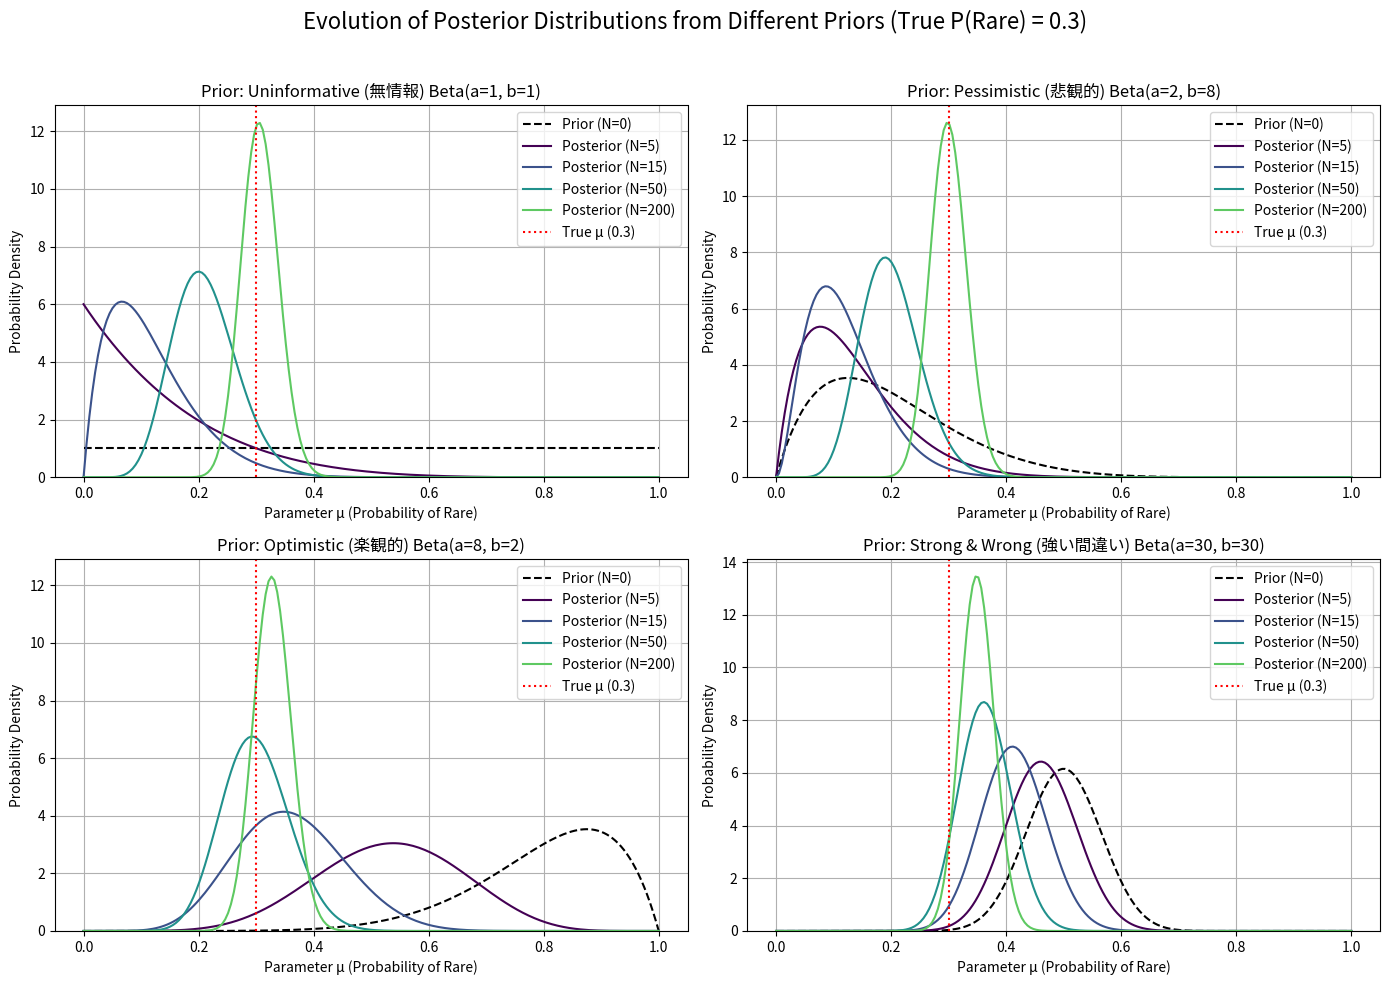

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta


def plot_distribution_evolution(ax, prior_a, prior_b, true_mu=0.3, num_trials=200):
    """
    事前分布がデータによって事後分布にどう変化するかを描画する関数
    """
    # --- データ生成 ---
    # 乱数シードを固定して毎回同じデータセットを生成
    np.random.seed(0)
    data = np.random.rand(num_trials) < true_mu

    # x軸 (確率μ) の値を設定
    x = np.linspace(0, 1, 200)

    # --- 事前分布を描画 ---
    ax.plot(
        x,
        beta.pdf(x, prior_a, prior_b),
        color="black",
        linestyle="--",
        label=f"Prior (N=0)",
    )

    # --- 特定の試行回数での事後分布を描画 ---
    plot_points = [5, 15, 50, 200]
    colors = plt.cm.viridis(np.linspace(0, 1, len(plot_points) + 1))

    for i, n in enumerate(plot_points):
        # n回目までのデータ
        current_data = data[:n]
        N1 = np.sum(current_data)
        N0 = len(current_data) - N1

        # 事後分布のパラメータ
        a_hat = prior_a + N1
        b_hat = prior_b + N0

        # 事後分布のPDFを描画
        ax.plot(
            x, beta.pdf(x, a_hat, b_hat), color=colors[i], label=f"Posterior (N={n})"
        )

    # 真の値を表示
    ax.axvline(x=true_mu, color="r", linestyle=":", label=f"True μ ({true_mu})")

    ax.set_xlabel("Parameter μ (Probability of Rare)")
    ax.set_ylabel("Probability Density")
    ax.grid(True)
    ax.legend()
    ax.set_ylim(bottom=0)


# --- 複数の事前分布でシミュレーションを実行 ---
priors = [
    {"a": 1, "b": 1, "title": "Uninformative (無情報)"},
    {"a": 2, "b": 8, "title": "Pessimistic (悲観的)"},
    {"a": 8, "b": 2, "title": "Optimistic (楽観的)"},
    {"a": 30, "b": 30, "title": "Strong & Wrong (強い間違い)"},
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    "Evolution of Posterior Distributions from Different Priors (True P(Rare) = 0.3)",
    fontsize=16,
)
axes = axes.flatten()

for i, p in enumerate(priors):
    plot_distribution_evolution(axes[i], p["a"], p["b"])
    axes[i].set_title(f"Prior: {p['title']} Beta(a={p['a']}, b={p['b']})")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
